# AUTONORMALIZE DEMO 
Using Autonormalize to normalize a kaggle dataset about liquor purchasing orders.

In [1]:
import os

import pandas as pd
import autonormalize as an

In [2]:
liquor_df = pd.read_csv(os.path.join(os.getcwd(), 'autonormalize/downloads/liquor.csv'))
liquor_df = liquor_df.drop(columns=liquor_df.columns[12:])
liquor_df = liquor_df.drop(range(3000000, 12591077))
liquor_df_smaller = liquor_df.drop(range(1500000, 3000000))
liquor_df = liquor_df.dropna()
liquor_df = liquor_df.drop_duplicates()
liquor_df_smaller = liquor_df_smaller.dropna()
liquor_df_smaller = liquor_df_smaller.drop_duplicates()
liquor_df.head(3)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name
6,S28865700001,11/09/2015,2538,Hy-Vee Food Store #3 / Waterloo,1422 FLAMMANG DR,WATERLOO,50702,"1422 FLAMMANG DR\nWATERLOO 50702\n(42.459938, ...",7.0,Black Hawk,1701100.0,DECANTERS & SPECIALTY PACKAGES
8,S29339300091,11/30/2015,2662,Hy-Vee Wine & Spirits / Muscatine,"522 MULBERRY, SUITE A",MUSCATINE,52761,"522 MULBERRY, SUITE A\nMUSCATINE 52761\n",70.0,Muscatine,1701100.0,DECANTERS & SPECIALTY PACKAGES
13,S28866900001,11/11/2015,3650,"Spirits, Stogies and Stuff",118 South Main St.,HOLSTEIN,51025,118 South Main St.\nHOLSTEIN 51025\n(42.490073...,47.0,Ida,1701100.0,DECANTERS & SPECIALTY PACKAGES


In [3]:
deps_approx = an.find_dependencies(liquor_df_smaller, 0.96)
print(deps_approx)

100%|██████████| 11/11 [11:10<00:00, 48.92s/it]


 --> Invoice/Item Number
 {Invoice/Item Number}  --> Date
 {Invoice/Item Number}  {Address}  {Store Name}  {Store Location}  --> Store Number
 {Invoice/Item Number}  {Store Number}  {Address}  {Store Location}  --> Store Name
 {Invoice/Item Number}  {Store Number}  {Store Name}  {Store Location}  --> Address
 {Zip Code}  {Address}  {Invoice/Item Number}  {Store Number}  {Store Name}  {Store Location}  --> City
 {Address}  {Invoice/Item Number}  {Store Number}  {Store Name}  {Store Location}  --> Zip Code
 {Address}  {Invoice/Item Number}  {Store Number}  {Store Name}  --> Store Location
 {Zip Code}  {County}  {Address}  {City}  {Invoice/Item Number}  {Store Number}  {Store Name}  {Store Location}  --> County Number
 {Zip Code}  {County Number}  {Address}  {City}  {Invoice/Item Number}  {Store Number}  {Store Name}  {Store Location}  --> County
 {Invoice/Item Number}  {Category Name}  --> Category
 {Invoice/Item Number}  {Category}  --> Category Name


In [4]:
groupings = an.normalize_dependencies(deps_approx)
for grp in groupings:
    print('\n~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~\n')
    print(grp)


~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

 --> Invoice/Item Number
 {Invoice/Item Number}  --> Date
 {Invoice/Item Number}  --> Address
 {Invoice/Item Number}  --> Category Name

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

 {Category}  --> Category Name
 {Category Name}  --> Category

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

 {Store Number}  {Store Name}  {Store Location}  --> Address
 {Address}  {Store Name}  {Store Location}  --> Store Number
 {Store Number}  {Address}  {Store Location}  --> Store Name
 {Address}  {Store Number}  {Store Name}  {Store Location}  --> Zip Code
 {Address}  {Store Number}  {Store Name}  --> Store Location

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

 --> Zip Code
 {Zip Code}  --> City

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

 --> City
 {City}  --> County

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

 {County Number}  --> County
 {County}  --> County Number


In [ ]:
import time
start = time.time()
new_dfs = an.split_dataframe(liquor_df_smaller, groupings)
end = time.time()
end-start

In [5]:
import featuretools as ft

In [6]:
entity_set = an.make_entity_set(liquor_df_smaller, groupings, id='liquor_orders')

In [7]:
entity_set

Entityset: liquor_orders
  Entities:
    Invoice/Item Number [Rows: 1497599, Columns: 4]
    Category Name [Rows: 73, Columns: 2]
    Address [Rows: 1505, Columns: 5]
    Zip Code [Rows: 422, Columns: 2]
    City [Rows: 395, Columns: 2]
    County [Rows: 99, Columns: 2]
  Relationships:
    Invoice/Item Number.Address -> Address.Address
    Invoice/Item Number.Category Name -> Category Name.Category Name
    Address.Zip Code -> Zip Code.Zip Code
    Zip Code.City -> City.City
    City.County -> County.County

In [9]:
entity_set = ft.EntitySet(id = "liquor_orders")
entity_set.entity_from_dataframe(entity_id="invoices", dataframe = new_dfs[0], index='Invoice/Item Number')
entity_set.entity_from_dataframe(entity_id="categories", dataframe = new_dfs[1], index='Category Name')
entity_set.entity_from_dataframe(entity_id="stores", dataframe = new_dfs[2], index='Store Name')
entity_set.entity_from_dataframe(entity_id='zip codes', dataframe = new_dfs[3], index='Zip Code')
entity_set.entity_from_dataframe(entity_id='cities', dataframe = new_dfs[4], index='City')
entity_set.entity_from_dataframe(entity_id='counties', dataframe = new_dfs[5], index='County')


Entityset: liquor_orders
  Entities:
    invoices [Rows: 1497599, Columns: 4]
    categories [Rows: 73, Columns: 2]
    stores [Rows: 1532, Columns: 5]
    zip codes [Rows: 422, Columns: 2]
    cities [Rows: 395, Columns: 2]
    counties [Rows: 99, Columns: 2]
  Relationships:
    No relationships

In [10]:
relationship_categories = ft.Relationship(entity_set['categories']['Category Name'], entity_set['invoices']['Category Name'])
relationship_stores = ft.Relationship(entity_set['stores']['Store Name'], entity_set['invoices']['Store Name'])
relationship_zips = ft.Relationship(entity_set['zip codes']['Zip Code'], entity_set['stores']['Zip Code'])
relationship_cities = ft.Relationship(entity_set['cities']['City'], entity_set['zip codes']['City'])
relationship_counties = ft.Relationship(entity_set['counties']['County'], entity_set['cities']['County'])

entity_set.add_relationships([relationship_categories, relationship_stores, relationship_zips, relationship_cities, relationship_counties])


Entityset: liquor_orders
  Entities:
    invoices [Rows: 1497599, Columns: 4]
    categories [Rows: 73, Columns: 2]
    stores [Rows: 1532, Columns: 5]
    zip codes [Rows: 422, Columns: 2]
    cities [Rows: 395, Columns: 2]
    counties [Rows: 99, Columns: 2]
  Relationships:
    invoices.Category Name -> categories.Category Name
    invoices.Store Name -> stores.Store Name
    stores.Zip Code -> zip codes.Zip Code
    zip codes.City -> cities.City
    cities.County -> counties.County

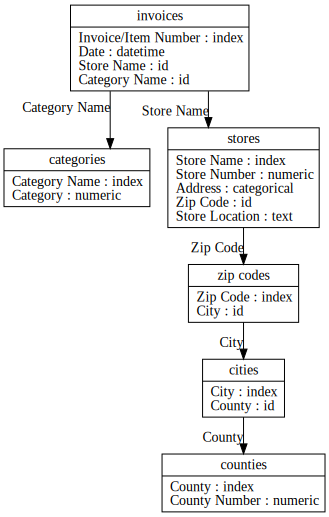

In [11]:
entity_set.plot()

In [15]:
for entity in entity_set:
    print(entity)

KeyError: 'Entity 0 does not exist in liquor_orders'